# Analysis Techniques - Statistical Methods - Index


## Universidade de Santiago 

---

## Hypothesis testing composite, KamLAND-Zen example


*Author: Jose A. Hernando*, February 2021

*Instituto Galego de Altas Enerxías. Universidade de Santiago de Compostela, Spain.*

In [1]:
import time
print( ' Last Execution ', time.asctime())

 Last Execution  Wed Feb 24 17:17:50 2021


In [2]:
# general imports
%matplotlib inline
%reload_ext autoreload
%autoreload 2
 
# numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats    as stats
import scipy.optimize as optimize


plt.style.context('seaborn-colorblind');

## Introduction


Use KamLAND-Zen article as example for composite hypothesis testing

**Exercise**: Consider the expected bacground events and signal events in bins of energy in the RoI of the KamLAND-Zen experiment in Fig 2-b) [PRL-117](https://arxiv.org/abs/1605.02889). Compute the p-value of H0, the 90% CL F.C interval for the strength parameter $\mu$.


*Guide:* 

From Fig 2-b) Period II we can extract the following number of background, signal and observed events.

*b* = [4.0, 2.0, 1.6, 1.0, 0.8, 0.7, 0.6, 0.5, 0.5, 0.5, 0.6, 0.6, 0.8, 1.1]

*s* = [0.2, 0.4, 0.5, 0.6, 0.5, 0.4, 0.2, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0]

*x* = [4.0, 0.0, 2.0, 4.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0]

In [3]:
b  = [4.0, 2.0, 1.6, 1.0, 0.8, 0.7, 0.6, 0.5, 0.5, 0.5, 0.6, 0.6, 0.8, 1.1]
s  = [0.2, 0.4, 0.5, 0.6, 0.5, 0.4, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0]
x0 = [4.0, 0.0, 2.0, 4.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0]

In [4]:
class NBinsStats:
    
    def __init__(self, b, s):
        self.b = np.copy(b)
        self.s = np.copy(s)
        return
        
    def rvs(self, mu = 0., size = 1):
        xs = [stats.poisson.rvs(bi + mu * si, size = size) for bi, si in zip(self.b, self.s)]
        ys = [[xi[j] for xi in xs] for j in range(size)]
        return  ys
    
    def llike(self, n, mu = 0.):
        y =  np.sum([stats.poisson.logpmf(ni, bi + mu * si) for ni, bi, si in zip(n, b, s)])
        return y

    def muhat(self, x):
        fun = lambda mu: -2 * self.llike(x, mu)
        res = optimize.minimize(fun, 1., bounds = ((0., np.inf),))
        mhat = res.x[0] if res.success else 0.
        return mhat
    
    def tmu(self, x, mu, muhat = None):
        mhat = self.muhat(x) if muhat is None else muhat
        ts   = -2 * self.llike(x, mu) + 2 * self.llike(x, mhat)
        return ts
        
    
def pvalue(q, qs):
    sel = qs >= q
    return (np.sum(sel)/len(qs))


### compute the espected mu value for the data

In [5]:
nbins = NBinsStats(b, s)

muhat = nbins.muhat(x0)
print('mu_hat(x_0) = {:6.4f}'.format(muhat))

mu_hat(x_0) = 0.2928


### Scan on $ -2 \Delta \log \mathcal{L}$

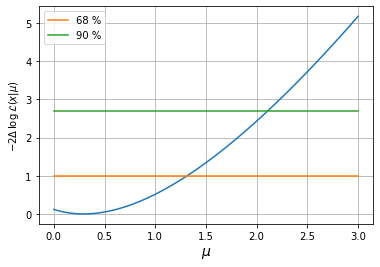

In [6]:
mus = np.linspace(0., 3., 100)
plt.plot(mus, [nbins.tmu(x0, mu, muhat) for mu in mus]);
plt.plot((0., 3.), (1.0, 1.0), label = '68 %')
plt.plot((0., 3.), (2.7, 2.7), label = '90 %')
plt.grid(); plt.legend();
plt.ylabel(r"$-2 \Delta \, \log \, \mathcal{L}(x|\mu)$"); plt.xlabel(r'$\mu$', fontsize = 14);

### Compute the p-value of the null hypothesis $(\mu_0 = 0)$

   * generate m-experiment with $\mu_0$, $\{ x\}_{\mu_0}$
   
   * compute $\hat{\mu}$ for each experiment, $\{\hat{\mu}(x) \}_{\mu_0}$
   
   * compute the distribution of FC test-statistics for $\mu_0$, $\{ q_0(x)\}_{\mu_0}$
   
   * compute the FC test-estatiscis for the observation $x_0$ and $\mu_0$, $q_0$.
   
   * compute the p-value, the fraction of experiments with equal or worse test-estatistic than the data.

In [7]:
### Generate n-experiments with hipothesis mu = 0
mu0     = 0.
size    = 10000
x0s    = nbins.rvs(mu = mu0, size = size)

777 [3, 2, 3, 1, 1, 0, 0, 1, 0, 1, 1, 4, 0, 1]


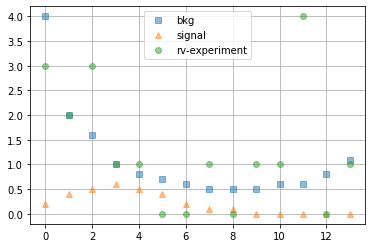

In [8]:
i = int(np.random.choice(range(size), 1)[0])
print(i, x0s[i])
plt.plot(b     , marker = 's', ls = '', alpha = 0.5, label = 'bkg');
plt.plot(s     , marker = '^', ls = '', alpha = 0.5, label = 'signal');
plt.plot(x0s[i], marker = 'o', ls = '', alpha = 0.5, label = 'rv-experiment');
plt.grid(); plt.legend(); 

In [9]:
# compute the best-estimate value mu for the random experiments with mu0
muhats = [nbins.muhat(xi) for xi in x0s]

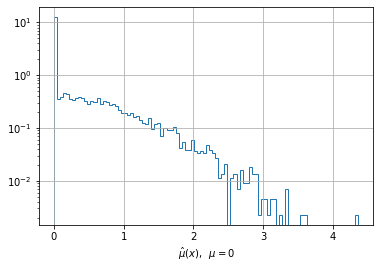

In [10]:
plt.hist(muhats, 100, histtype = 'step', density = True); 
plt.yscale('log'); plt.grid();
plt.xlabel(r'$\hat{\mu}(x), \;\; \mu = 0$');

In [11]:
## compute the FC test-statiscits for the experiments with mu_0
q0s = [nbins.tmu(xi, mu0, muhat) for xi, muhat in zip(x0s, muhats)]

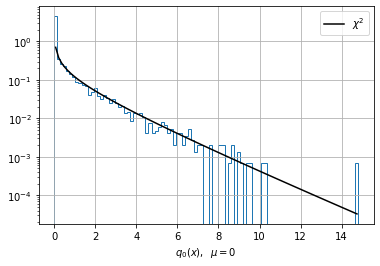

In [12]:
counts, bins, _ = plt.hist(q0s, 100, histtype = 'step', density = True); plt.yscale('log');
xbins  = 0.5* (bins[:-1] + bins[1:])
factor = bins[1] - bins[0]
chi2   = stats.chi2(1)
plt.plot(xbins, 0.5 * chi2.pdf(xbins), color = 'black', label = r'$\chi^2$');
plt.grid(); plt.legend();
plt.xlabel(r'$q_0(x), \;\; \mu = 0$');

The agreement between the FC test-stats and the half $\chi^2$ indicates that we are under the Wilk's theoreme regime.

### Compute the p-value of the $H_0$ hypothesis

In [13]:
q0 = nbins.tmu(x0, mu = mu0)
p0 = pvalue(q0, q0s)
print('q0         : {:6.5f}'.format(q0))
print('H0 p-value : {:6.5f}'.format(p0))

q0         : 0.11828
H0 p-value : 0.34250


### Compute the 90 % C.I

In [14]:
mu1  = 2.1
size = 10000
x1s  = nbins.rvs(mu = mu1, size = size)

In [15]:
mu1hats = [nbins.muhat(xi) for xi in x1s]

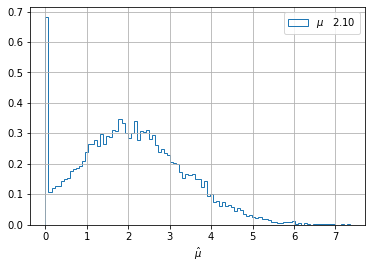

In [16]:
plt.hist(mu1hats, 100, histtype = 'step', density = True, label = r'$\mu $ {:6.2f}'.format(mu1));
plt.xlabel(r'$\hat{\mu}$'); plt.grid(); plt.legend();

In [17]:
## compute the FC test-statiscits for the experiments with mu_0
q1s   = [nbins.tmu(xi, mu1, muhat) for xi, muhat in zip(x1s, mu1hats)]

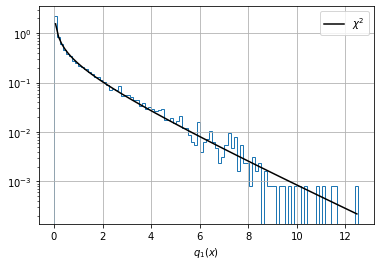

In [18]:
counts, bins, _ = plt.hist(q1s, 100, histtype = 'step', density = True); plt.yscale('log');
xbins  = 0.5* (bins[:-1] + bins[1:])
factor = bins[1] - bins[0]
chi2   = stats.chi2(1)
plt.plot(xbins,  chi2.pdf(xbins), color = 'black', label = r'$\chi^2$');
plt.grid(); plt.legend();
plt.xlabel(r'$q_1(x)$');

In [19]:
q1 = nbins.tmu(x0, mu1)
print(q1)
p1 = pvalue(q1, q1s)
print(p1)

2.6770561914108697
0.111


In [20]:
print('mu1        : {:6.5f}'.format(mu1))
print('q1         : {:6.5f}'.format(q1))
print('H1 p-value : {:6.5f}'.format(p1))

mu1        : 2.10000
q1         : 2.67706
H1 p-value : 0.11100


The $\mu$ strengthparameter CI at 90% CL using F.C is: $[0, \; 2.1]$

### Compute the exclusion of $\mu$

In [21]:
q1s   = np.array(q1s); mu1hats = np.array(mu1hats)
q1s_u = np.copy(q1s)
q1s_u[mu1hats > mu1] = 0

In [22]:
p1 = pvalue(q1, q1s_u)
print('mu1        : {:6.5f}'.format(mu1))
print('q1         : {:6.5f}'.format(q1))
print('H1 p-value : {:6.5f}'.format(p1))

mu1        : 2.10000
q1         : 2.67706
H1 p-value : 0.06310


Strength parameter $\mu = 2.1$ is excluded at 0.96 % CL

### Using single hypothesis for $\mu_0 = 0, \; \mu_1 = 2.1$

In [27]:
mu0, mu1 = 0., 2.1
sq0s = [nbins.tmu(xi, mu0, mu1) for xi in x0s]
sq1s = [nbins.tmu(xi, mu0, mu1) for xi in x1s] 

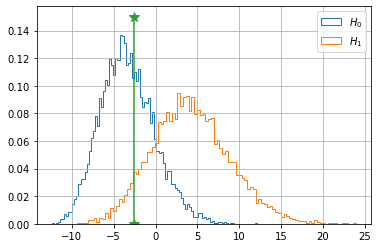

In [28]:
plt.hist(sq0s, 100, label = r'$H_0$', density = True, histtype = 'step')
plt.hist(sq1s, 100, label = r'$H_1$', density = True, histtype = 'step');
plt.grid(); plt.legend()

sq0  = nbins.tmu(x0, mu0, mu1)
plt.plot((sq0, sq0), (0, 0.15), marker = '*', ms = 10)

In [29]:
p0 = pvalue(sq0, sq0s)
p1 = 1. - pvalue(sq0, sq1s)
print('q0         : {:6.5f}'.format(sq0))
print('H0 p-value : {:6.5f}'.format(p0))
print('H1 p-value : {:6.5f}'.format(p1))

q0         : -2.55878
H0 p-value : 0.37960
H1 p-value : 0.06550


We have validated that both methods give the same result in terms of p-values for $H_0(\mu = 0)$ and $H_1(\mu = 2.1)$.